In [1]:
import pygmt
import pandas as pd
import xarray as xr
from scipy.spatial import cKDTree
import rioxarray

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Calculate distances to nearest constraints

In [2]:
constraints = pd.read_csv('..bedmachine_RIGGS.csv', index_col=False,) # from RIS_bathymetry_data.ipynb
grid=xr.load_dataset('../bathymetry_data/bedmachine_clip.nc') # from RIS_bathymetry_data.ipynb

A = grid.to_dataframe().reset_index()[['x','y']].values
B = constraints[['x','y']].values

min_dists, min_dist_idx = cKDTree(B).query(A,1)

dists = pd.DataFrame(A, columns=('x','y'))
dists['min_dists']=min_dists

dist_grid = pygmt.xyz2grd(dists, region='../bathymetry_data/bedmachine_clip.nc', spacing=1000)
dist_grid#.plot()

<xarray.DataArray 'z' (y: 2961, x: 2961)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.56e+06 -1.559e+06 -1.558e+06 ... 1.399e+06 1.4e+06
  * y        (y) float64 -2.4e+06 -2.399e+06 -2.398e+06 ... 5.59e+05 5.6e+05
Attributes:
    long_name:     z
    actual_range:  [    0.         61909.85546875]

In [ ]:
# dist_grid.isel(x=slice(1200,1600), y=slice(1200,1600)).plot()

In [3]:
outer = 30e3
inner = 2e3
# if distance to nearest constraint > outer, set to 1 (fully free to invert)
# if distance to nearest constraint < inner, set to 0 (completely constrained)
# if distance to nearest constraint between inner and out, set to NaN 
dist_clip = pygmt.grdclip(
    dist_grid, 
    above=[outer,1],
    below=[inner,0],
    between=[inner, outer, 'NaN']
    )
dist_clip#.plot()

<xarray.DataArray 'z' (y: 2961, x: 2961)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.56e+06 -1.559e+06 -1.558e+06 ... 1.399e+06 1.4e+06
  * y        (y) float64 -2.4e+06 -2.399e+06 -2.398e+06 ... 5.59e+05 5.6e+05
Attributes:
    long_name:     z
    actual_range:  [0. 1.]

In [ ]:
# dist_clip.isel(x=slice(1200,1600), y=slice(1200,1600)).plot()

In [4]:
# if distance between inner and outer, linearly increase from 0 to 1
dist_clip=dist_clip.rio.write_crs("epsg:3031")
constraints_grid = dist_clip.rio.interpolate_na(method='linear')
constraints_grid#.plot()

<xarray.DataArray 'z' (y: 2961, x: 2961)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 -1.56e+06 -1.559e+06 ... 1.399e+06 1.4e+06
  * y            (y) float64 -2.4e+06 -2.399e+06 -2.398e+06 ... 5.59e+05 5.6e+05
    spatial_ref  int64 0
Attributes:
    long_name:     z
    actual_range:  [0. 1.]

In [ ]:
# constraints_grid.isel(x=slice(1200,1600), y=slice(1200,1600)).plot()

In [6]:
constraints_grid.to_netcdf('constraints_grid.nc')
xr.load_dataset('constraints_grid.nc').z#.plot()

<xarray.DataArray 'z' (y: 2961, x: 2961)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.56e+06 -1.559e+06 -1.558e+06 ... 1.399e+06 1.4e+06
  * y        (y) float64 -2.4e+06 -2.399e+06 -2.398e+06 ... 5.59e+05 5.6e+05
Attributes:
    long_name:     z
    actual_range:  [0. 1.]
    grid_mapping:  spatial_ref

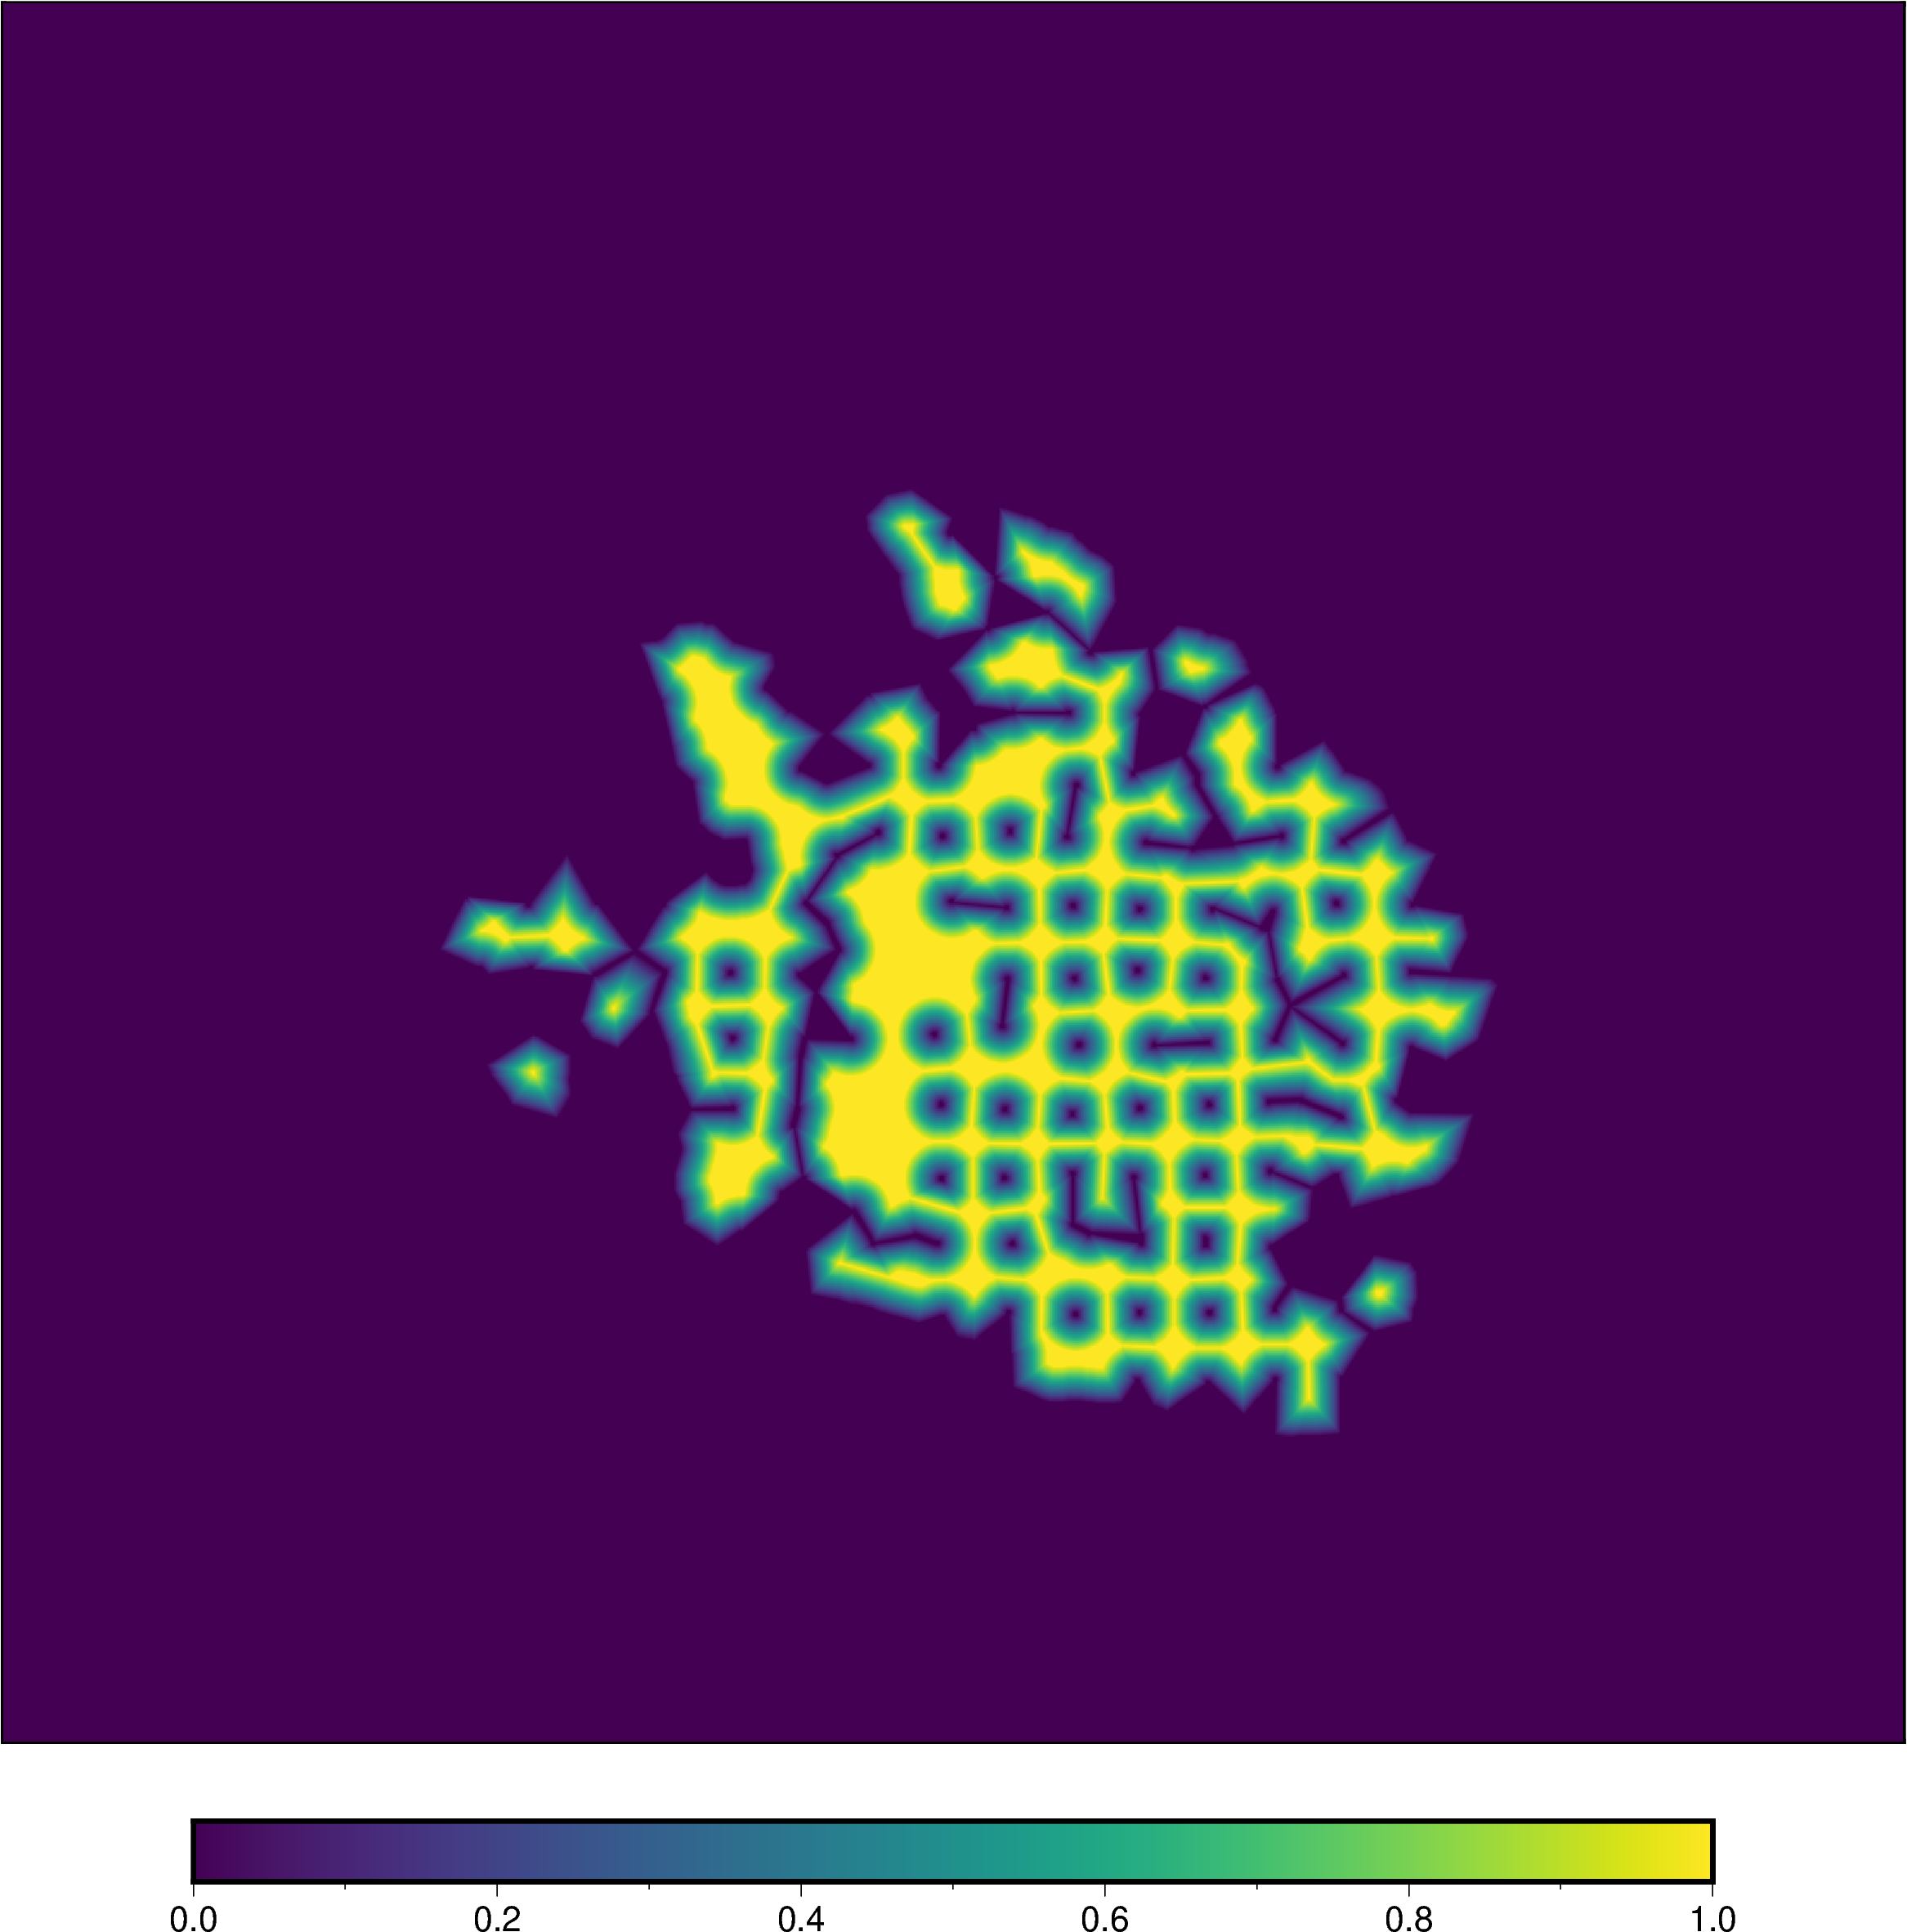

In [8]:
n = -1600e3 
e = -860e3 
s = -200e3 
w = 670e3
    
fig_height = 180 # in mm
fig_width = fig_height*(w-e)/(s-n)
fig_ratio = (s-n)/(fig_height/1000)

fig_reg = f'{e}/{w}/{n}/{s}'
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

barwidth = fig_width/10 * 0.8 # color bar width is 40% of the map width, in cm
pos_str = f'jBC+w{barwidth}c/.5c+jTC+o0c/.2c+h+e'

fig = pygmt.Figure()
  
# add white background and frame
fig.coast(region = fig_reg, projection = fig_proj_ll, land = 'white', water = 'white', 
            frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
    
# plot graticules overtop, at 4d latitude and 30d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black', 
                MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                MAP_POLAR_CAP = '90/90', ):
    fig.basemap(projection = fig_proj_ll, frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')

fig.grdimage(projection=fig_proj, grid='constraints_grid.nc', cmap='viridis')

fig.colorbar(cmap=True)

fig.show()